<a href="https://colab.research.google.com/github/PutriAuliaKusnadi/PengolahanCitraDigital/blob/main/face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Impor pustaka Python yang diperlukan
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

Beberapa fungsi pembantu untuk melakukan konversi antara tipe dan format data gambar yang berbeda.

In [16]:
# berfungsi untuk mengubah objek JavaScript menjadi gambar OpenCV
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # mendekode gambar base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # mengkonversi byte ke array numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode array numpy ke dalam gambar OpenCV BGR
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# berfungsi untuk mengubah gambar kotak pembatas Persegi Panjang OpenCV menjadi string byte base64 untuk dialihkan pada aliran video
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # mengubah array menjadi gambar PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox ke png untuk pengembalian
  bbox_PIL.save(iobuf, format='png')
  # format pengembalian string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

Menjalankan algoritma pendeteksian objek sederhana yang disebut Haar Cascade pada gambar dan video kita yang diambil dari webcam kita. OpenCV memiliki model deteksi wajah Haar Cascade yang telah dilatih sebelumnya.

In [17]:
# menginisialisasi model deteksi wajah Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

Webcame Images

In [18]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Ubah ukuran keluaran agar sesuai dengan elemen video.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      //Tunggu hingga Tangkap diklik.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # mendapatkan data foto
  data = eval_js('takePhoto({})'.format(quality))
  # dapatkan gambar format OpenCV
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # dapatkan koordinat kotak pembatas wajah menggunakan Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # menggambar kotak pembatas wajah pada gambar
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # Simpan foto
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


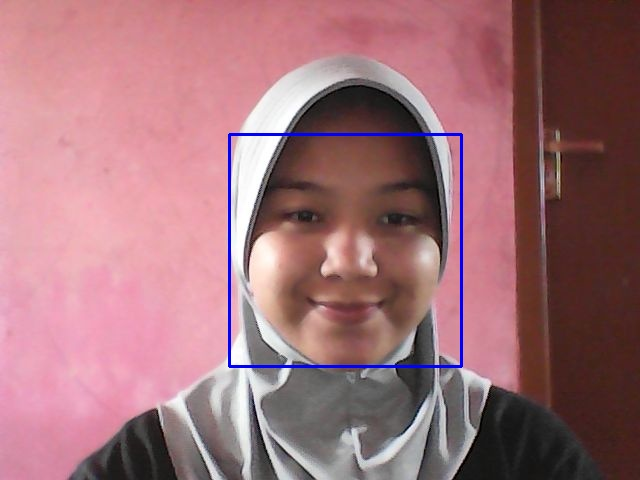

In [22]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Tunjukkan gambar yang baru saja diambil.
  display(Image(filename))
except Exception as err:
  # Kesalahan akan terjadi jika pengguna tidak memiliki webcam atau jika tidak
  # berikan izin halaman untuk mengaksesnya.
  print(str(err))

Webcame Video

In [20]:
# JavaScript untuk membuat aliran video langsung dengan benar menggunakan webcam sebagai masukan
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [23]:
# mulai streaming video dari webcam
video_stream()
# label untuk video
label_html = 'Capturing...'
# inisialisasi kotak pembatas menjadi kosong
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # mengonversi respons JS ke Gambar OpenCV
    img = js_to_image(js_reply["img"])

    # buat hamparan transparan untuk kotak pembatas
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # gambar skala abu-abu untuk deteksi wajah
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # mendapatkan koordinat wilayah wajah
    faces = face_cascade.detectMultiScale(gray)
    # dapatkan kotak pembatas wajah untuk overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # mengubah overlay bbox menjadi byte
    bbox_bytes = bbox_to_bytes(bbox_array)
    # perbarui bbox sehingga frame berikutnya mendapat overlay baru
    bbox = bbox_bytes

<IPython.core.display.Javascript object>